In [1]:
import os
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
import shutil
import random


### Resize and pad

In [ ]:

def create_output_dirs(base_dir):
    os.makedirs(os.path.join(base_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(base_dir, "masks"), exist_ok=True)
    
def resize_and_pad(img, size=512, pad_color=0):
    h, w = img.shape[:2]
    
    scale = size / max(h, w)
    new_h = int(scale * h)
    new_w = int(scale * w)
    
    # Resize with INTER_AREA for Downsampling, INTER_LINEAR for Upsampling
    if scale < 1: 
        interpolation = cv2.INTER_AREA
    else:
        interpolation = cv2.INTER_LINEAR
        
    img_resized = cv2.resize(img, (new_w, new_h), interpolation=interpolation)
    
    # Padding
    pad_w = size - new_w
    pad_h = size - new_h
    
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    
    img_padded = cv2.copyMakeBorder(img_resized, top, bottom, left, right, borderType=cv2.BORDER_CONSTANT, value=pad_color)
    
    return img_padded
    

def resize_pad_and_save(
    image_path: str,
    mask_path: str,
    output_dir: str,
    size: int = 512,
):
    try:
        create_output_dirs(output_dir)
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        image = resize_and_pad(image, size=size, pad_color=(0,0,0))
        mask = resize_and_pad(mask, size=size, pad_color=0)
        
        basename = os.path.basename(image_path)
        # if basename.startswith("o_"): 
        #     return
        
        filename = os.path.splitext(basename)[0]
        
        if filename != os.path.splitext(os.path.basename(mask_path))[0]:
            return
        
        save_img_path = os.path.join(output_dir, f"images/{filename}.png")
        save_mask_path = os.path.join(output_dir, f"masks/{filename}.png")
                    
        cv2.imwrite(save_img_path, image)
        cv2.imwrite(save_mask_path, mask)
        
    except Exception as e:
        print(e)
        pass
                

In [15]:
def resize_images_in_folder(folder, output_dir):
    images_path = sorted([os.path.join(os.path.join(folder, 'im'), file) for file in os.listdir(os.path.join(folder, 'im'))])
    masks_path = sorted([os.path.join(os.path.join(folder, 'gt'), file) for file in os.listdir(os.path.join(folder, 'gt'))])

    for img_path, mask_path, idx in tqdm(
        zip(
            images_path, masks_path, range(len(masks_path))),
            total=len(masks_path),
            desc="Processing pairs of images"):
        basename = os.path.basename(img_path)
        
        resize_pad_and_save(
            image_path=img_path,
            mask_path=mask_path,
            output_dir=output_dir,
            size=512
        )

    print(f"Num images: {len(os.listdir(output_dir + "/masks"))}")

In [17]:
data_folder = "../../human_data"
output_dir = "../../resized_and_padded"
for sub_folder in os.listdir(data_folder):
    print(f"Resizing images in {sub_folder}")
    folder = os.path.join(data_folder, sub_folder)
    resize_images_in_folder(folder, output_dir)
    

Resizing images in human_1


Processing pairs of images: 100%|██████████| 623/623 [00:39<00:00, 15.70it/s]


Num images: 623
Resizing images in human_2


Processing pairs of images:  18%|█▊        | 109/601 [00:07<00:17, 28.18it/s]

'NoneType' object has no attribute 'shape'


Processing pairs of images: 100%|██████████| 601/601 [00:15<00:00, 37.74it/s]


Num images: 723
Resizing images in human_3


Processing pairs of images:  22%|██▏       | 1581/7217 [00:49<03:01, 31.13it/s]

'NoneType' object has no attribute 'shape'


Processing pairs of images: 100%|██████████| 7217/7217 [04:14<00:00, 28.31it/s]


Num images: 7939
Resizing images in human_4


Processing pairs of images: 100%|██████████| 290/290 [00:02<00:00, 96.93it/s] 


Num images: 8229
Resizing images in human_5


Processing pairs of images: 100%|██████████| 2667/2667 [01:32<00:00, 28.83it/s]

Num images: 10896


In [18]:
# Check for matching image and mask names. 
image_names = sorted(os.listdir(output_dir + "/images"))
mask_names = sorted(os.listdir(output_dir + "/masks"))

ct = 0
for img_name, msk_name in zip(image_names, mask_names):
    if os.path.splitext(img_name)[0] != os.path.splitext(msk_name)[0]:
        ct += 1
        
print(f"Found {ct} non-matching pairs")


Found 0 non-matching pairs


In [19]:
# Augmentation
def get_patch_augmentation():
    return A.Compose([
        A.HorizontalFlip(p=0.7),
        A.SafeRotate(limit=45, p=0.7),
        A.RandomBrightnessContrast(p=0.7),
        A.GaussianBlur(blur_limit=(3, 5), p=0.7),
    ])

def augment_and_save_patch(img_path, mask_path, output_img_dir, output_mask_dir, num_aug=3):
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    if base_name != os.path.splitext(os.path.basename(mask_path))[0]:
        return
    
        # Copy original
    shutil.copy(img_path, os.path.join(output_img_dir, f"{base_name}.png"))
    shutil.copy(mask_path, os.path.join(output_mask_dir, f"{base_name}.png"))

    aug = get_patch_augmentation()

    for i in range(num_aug):
        augmented = aug(image=img, mask=mask)
        aug_img = augmented['image']
        aug_mask = augmented['mask']
        cv2.imwrite(os.path.join(output_img_dir, f"{base_name}_aug_{i}.png"), aug_img)
        cv2.imwrite(os.path.join(output_mask_dir, f"{base_name}_aug_{i}.png"), aug_mask)
        

In [20]:
input_folder = "../../resized_and_padded"

out_folder = "../../augmented"

os.makedirs(os.path.join(out_folder, "images"), exist_ok=True)
os.makedirs(os.path.join(out_folder, "masks"), exist_ok=True)

images = os.listdir(os.path.join(input_folder, "images"))
masks = os.listdir(os.path.join(input_folder, "masks"))

for img_name, mask_name in tqdm(zip(images, masks), total=len(masks), desc="Processing pairs of image, mask"):
    img_path = os.path.join(input_folder, "images", img_name)
    mask_path = os.path.join(input_folder, "masks", mask_name)

    num_aug = random.randint(1, 2)
    augment_and_save_patch(
        img_path=img_path,
        mask_path=mask_path,
        output_img_dir=os.path.join(out_folder, "images"),
        output_mask_dir=os.path.join(out_folder, "masks"),
        num_aug=num_aug,
    )

Processing pairs of image, mask: 100%|██████████| 10896/10896 [05:26<00:00, 33.34it/s]


In [21]:
len(os.listdir(out_folder + "/images"))

27162

### Splitting into training, validation, and testing datasets

In [22]:
images_dir = "../../augmented/images"
masks_dir = "../../augmented/masks"

def list_sorted_files(folder_path, valid_exts=(".png", ".jpg", ".jpeg")):
    return sorted(
        f for f in os.listdir(folder_path) if f.lower().endswith(valid_exts)
    )

image_filenames = list_sorted_files(images_dir)
mask_filenames = list_sorted_files(masks_dir)

if len(image_filenames) != len(mask_filenames):
    raise ValueError(f"Number of images ({len(image_filenames)}) and masks ({len(mask_filenames)}) do not match.")

paired_file_paths = [
    (os.path.join(images_dir, image_name), os.path.join(masks_dir, mask_name))
    for image_name, mask_name in zip(image_filenames, mask_filenames)
]

for image_name, mask_name in zip(image_filenames, mask_filenames):
    if os.path.splitext(image_name)[0] != os.path.splitext(mask_name)[0]:
        raise ValueError(f"Filename mismatch: {image_name} vs {mask_name}")

random.shuffle(paired_file_paths)

In [23]:
def make_dirs(base_dir):
    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(base_dir, split, "images"), exist_ok=True)
        os.makedirs(os.path.join(base_dir, split, "masks"), exist_ok=True)
        
total = len(paired_file_paths)
train_end = int(total * 0.8)
val_end = int(total * 0.9)

splits = {
    "train": paired_file_paths[:train_end],
    "val": paired_file_paths[train_end:val_end],
    "test": paired_file_paths[val_end:]
}
output_dir = "../../data"
make_dirs(output_dir)

for split_name, pairs in splits.items():
    for img_path, mask_path in pairs:
        shutil.move(img_path, os.path.join(output_dir, split_name, "images", os.path.basename(img_path)))
        shutil.move(mask_path, os.path.join(output_dir, split_name, "masks", os.path.basename(mask_path)))

print("Dataset split and copy completed.")

Dataset split and copy completed.


In [24]:
len(os.listdir("../../data/train/images"))

21729

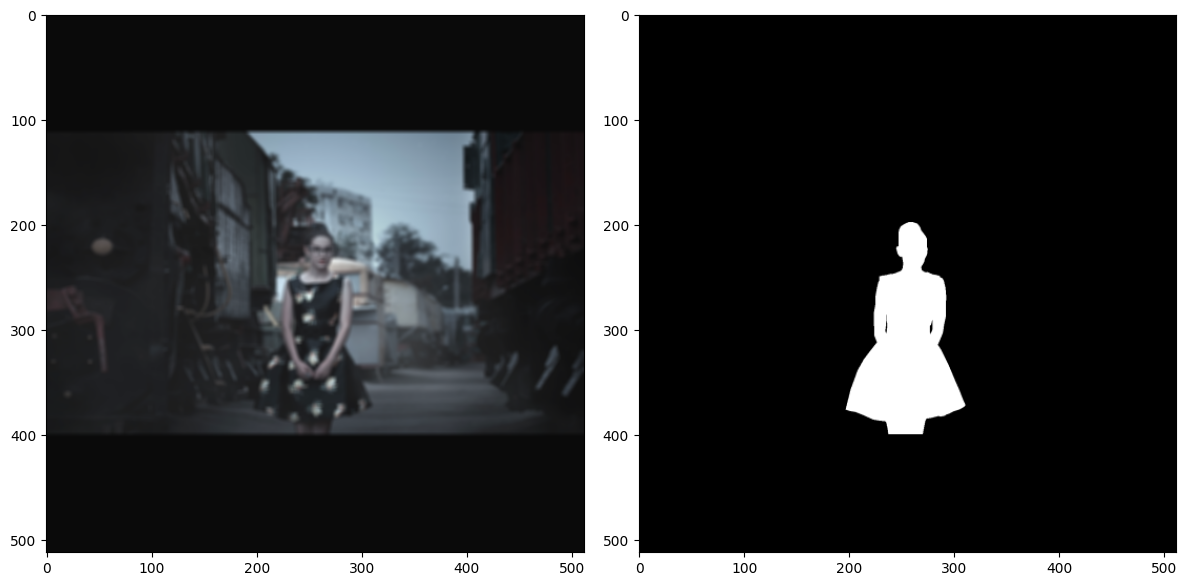

In [30]:
import random

images_dir = "../../data/train//images"
masks_dir = "../../data/train//masks"

images_path = [os.path.join(images_dir, file) for file in os.listdir(images_dir)]
masks_path = [os.path.join(masks_dir, file) for file in os.listdir(masks_dir)]

plt.figure(figsize=(12, 12))
N = 1
for count in range(N):
    idx = random.randint(0, len(images_path)-5)
    img_path, mask_path = images_path[idx], masks_path[idx]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    plt.subplot(N, 2, count * 2 + 1)
    plt.imshow(img)
    plt.subplot(N, 2, count * 2 + 2)
    plt.imshow(mask, cmap='gray')
    
plt.tight_layout()
plt.show()
